# Analysis Of Binghamton University's Men's Ultimate Frisbee Statisics


During this project, I recreated and improved the statistics application *UltiAnalytics*. Paired with a mobile, device, *UltiAnalytics* compiles a multitude of individual and team statistics. Raw statistics are first taken from a mobile device and then transferred to *UltiAnalytics's* main site. There, it is compiled and displayed in a graphical user interface. Features include filtering by game, seeing a flow chart of passes, and computing team statistics. A reference can be viewed [here](https://www.ultianalytics.com/app/index.html#/5781282907750400/players?game-0cc51f7d-2792-4fee-b4f8-24fe529675af).  


The raw data from this site is able to be downloaded. It must be proccsed and interpetted in order to formulate statistics. Many of the basic stats such as assists, goals, catches, drops were done in the same manner as the site. Some statiscs, however, like plusMinus, assistsToAssists, chanceOfScoring, breakChance, and brokenChance were created in hope of finding a deeper understanding of positively and negatively contributing players. More specifically, these analytics were developed in hope of getting a better understading of the following questions: 

* How valuable is a player? 
* What players are best at generating a break?
* What palyers get broken the most? 
* Is there a correlation between offensive and defense productively just by looking at their presense on the field?



### Similar Research

A similar project, *Analayzing Ultimate* was done by 4 Harvard ultimate frisbee players. They used a similar data set from the American Ultimate Disc League's (AUDL) 2015 season. Using Jupyter Notebook, they set out to answer the following questions: 

* Does the length of time of a point tell us anything about the performance of a team?
* Does the percentage of points broken when on offense or defense tell us anything about a team?
* What do statistics like, goals, assists, or throwaways, tell us about a player?

*Analyzing Ultmate*'s questions were similar to mine in the way that they also asked what does "good" ultimate look like statistically. What differed, however, was the scope of research.  *Analyzing Ultmate* looked at more team specific statistics while I found out what statistics related to the value of a player. 

### Compile and process data
Raw data was taken from UltiAnalytics. In order to generate statistics, the data had to be read and translated. The below algorothim has a range of `if` statements used to check what the current action is and increment or decrement the correct statistic. Each action has the following format: 

In [73]:
import pandas as pd 
df = pd.read_csv('BigBearStats.csv', index_col=2)
df.head(1)

,Date/Time,Tournamemnt,Point Elapsed Seconds,Line,Our Score - End of Point,Their Score - End of Point,Event Type,Action,Passer,Receiver,Defender,Hang Time (secs),Player 0,Player 1,Player 2,Player 3,Player 4,Player 5,Player 6,Player 7,Player 8,Player 9,Player 10,Player 11,Player 12,Player 13,Player 14,Player 15,Player 16,Player 17,Player 18,Player 19,Player 20,Player 21,Player 22,Player 23,Player 24,Player 25,Player 26,Player 27,Elapsed Time (secs),Begin Area,Begin X,Begin Y,End Area,End X,End Y,Distance Unit of Measure,Absolute Distance,Lateral Distance,Toward Our Goal Distance
Opponent,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Navy x,2022-10-12 09:57,Cav Cup,159,O,1,0,Offense,Catch,Sam,Ochen,NaN,NaN,Blaze,Juice,Ochen,Jack,Neil,Sam,Zla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from Player import *
from Main import processActions
figW = 16
figH = 5

pd.set_option('display.precision', 3)
pd.set_option('display.max_columns', None)
badColumns = ['Date/Time', 'Point Elapsed Seconds','Player 7', 'Player 8', 
           'Player 9', 'Player 10', 'Player 11', 'Player 12', 'Player 13', 'Player 14', 
           'Player 15', 'Player 16', 'Player 17', 'Player 18', 'Player 19', 'Player 20', 
           'Player 21', 'Player 22', 'Player 23', 'Player 24', 'Player 25', 'Player 26', 
           'Player 27', 'Elapsed Time (secs)', 'Begin X', 'Begin Y', 'End X', 'End Y', 
           'Distance Unit of Measure', 'Absolute Distance', 'Lateral Distance', 'Toward Our Goal Distance', 'Begin Area', 'End Area']
def getPlayers(df):
    players = {}
    playerColNames = ['Player 0', 'Player 1', 'Player 2', 'Player 3', 'Player 4', 'Player 5', 'Player 6']
    for col in playerColNames:
        for playerName in df[col]:
            curPlayer = Player(playerName)
            players.update({playerName: curPlayer})
    return players
df = df.drop(badColumns, axis=1)
players = getPlayers(df) 
playersDF = pd.DataFrame.from_records((vars(player) for player in list(players.values())), index='name')
df = df.rename(columns={'Tournamemnt': 'Tournament'})
players, pullsHangTime = processActions(df, players)
playersDF = pd.DataFrame.from_records((vars(player) for player in list(players.values())), index='name')
playersDF.drop(['pointsWhenPlaying', 'games','numGamesPlayed', 'pulls'], axis=1, inplace=True)

### How Data is Processed

Many classes were created for this project. A Main, Player, Game, and Test classes were all created in the hope of ogranizing the code. Each participant has an attached Player class that is pointed to by the players dictionary. Each Player has statistical attributes such as goals, points played, etc. All of these attributes are also abstracted out to individual games attached to each Player. Hence, each Players have a collection of Game objects in which the same attributes, assists, goals, points played, etc, are stored. 

##### The raw data is proccessed through the ProcessActions function in the Main class: 

```python
def getAttributes(curAction):
def processActions(df, players):
 curOpponent = ''
    ourScore = 0
    theirScore = 0
    startingEventType = ''
    pullHangtime = {}
    activePull = False
    activePullTime = 0.0
    newOpToScore = True
    prevPasser = 'Anonymous'
    for row in range(len(df)):
        curAction = df.iloc[row]
        name, game, line, eventType, action, passer, receiver, defender, hangTime, activePlayers, ourScoreEOP, theirScoreEOP = getAttributes(df.iloc[row])
        if startingEventType != eventType: 
            startingEventType = eventType
            if startingEventType == 'Offense':
              for player in activePlayers:
                players[player].incrOpsToScore()
        if name != curOpponent: ## new game
            curOpponent = name         
            ourScore = 0
            theirScore = 0
            startingEventType = eventType
        if ourScoreEOP != ourScore: ## after this action, we scored
            ourScore = ourScoreEOP
            activePull = False
            newOpToScore = True
            players = incrementPointsPlayed(curAction, players)
        elif theirScoreEOP != theirScore: ## after this action they score
            players = incrementPointsPlayed(curAction, players)
            theirScore = theirScoreEOP
            activePull = False
            newOpToScore = True
        if action == 'Goal' and line == 'D' and eventType == 'Offense':
            for player in activePlayers:
                players[player].incrNumBreaks()
        if action == 'Goal' and line == 'O' and eventType == 'Defense':
            for player in activePlayers:
                players[player].incrNumBroken()
        if defender != 'Anonymous':
            if action == 'Pull':
                players[defender].incrPulls(hangTime, game)
                activePullTime = hangTime
                pullHangtime[activePullTime] = False
                activePull = True
            elif action == 'PullOb':
                players[defender].incrPulls(0.0, game)
        if eventType == 'Offense':
            if newOpToScore:
                for player in activePlayers: 
                    players[player].incrOpsToScore()
                newOpToScore = False
            if action == 'Goal':
                players[passer].incrAssists(game)
                players[receiver].incrGoals(game)
                players[receiver].incrCatches(game)
                players[receiver].changePM(game, 1.0) ## They score, PM + 1
                players[passer].changePM(game, 0.8) ## They assist, PM + 0.8
                players[passer].changeOGPM(game, 1)
                players[receiver].changeOGPM(game, 1)
                for player in activePlayers: 
                    players[player].incrPointsWhenPlaying()
                    players[player].changePM(game, 0.15) ## They are on the field when we score, PM + 0.15
                if passer != 'Anonymous':
                    players[passer].incrCmpltn(game)
                if prevPasser != 'Anonymous':
                    players[prevPasser].incrATOA(game)
                    players[player].changePM(game, 0.33) ## Assist To Assist, PM +0.05
            elif action == 'Catch':
                players[receiver].incrCatches(game)
                prevPasser = passer
                if passer != 'Anonymous':
                    players[passer].incrCmpltn(game)
            elif action == 'Throwaway' and passer != 'Anonymous':
                players[passer].incrThrowaways(game)
                players[passer].changePM(game, -0.9)
                players[passer].changeOGPM(game, -1)
                for player in activePlayers: 
                    players[player].changePM(game, -0.1)
            elif action == 'Drop':
                players[receiver].incrDrops(game)
                players[receiver].changePM(game, -0.75)
                players[receiver].changeOGPM(game, -1)
                for player in activePlayers:
                    players[player].changePM(game, -0.05)
            elif action == 'Stall':
                players[passer].changePM(game, -1.0)
                players[passer].changeOGPM(game, -1)
        if eventType == 'Defense':
            if action == 'D' or action == 'Throwaway':
                if activePull:
                    pullHangtime[activePullTime] = True
                    activePull = False
                if action == 'D' and defender != 'Anonymous':
                    players[defender].incrDs(game)
                    players[defender].changePM(game, 0.9)
                    players[defender].changeOGPM(game, 1)
                    for player in activePlayers:
                        players[player].changePM(game, 0.05)
            elif action == 'Callahan':
                players[defender].changePM(game, 2)
                players[defender].changeOGPM(game, 2)
                for player in activePlayers:
                        players[player].changePM(game, 0.05)
    return (players, pullHangtime)
```


#### The Player Class
A Player class was created to organize the code better. Each player on the team gets assigned it's own Player object where statics such as `assists`, `goals`, `plusMinus`, etc are stored. All of these attributes ared attached to the object. Additional, methods such as `calcCatchingPercentage` are used in order to formulate computable statics for each player. Many of the function definitions have been removed for the sake of readability. Complete Player class can be found in Player.py.
```python

class Player:
    def avgeragePullHangtime(self):
        total = 0
        size = 0
        if len(self.pulls) == 0:
            return 0.0
        for pull in self.pulls: 
            if pull != 0.0:
                size += 1
                total += pull
        if size == 0:
            return 0.0
        return total/size
    def calcOBPulls(self):
        totalOB = 0
        for pull in self.pulls:
            if pull == 0.0:
                totalOB += 1
            return totalOB
    def calcCatchingPercent(self):
        if self.drops == 0: 
            return 0.0
        return (self.catches + self.drops) / self.drops
    def calcPassingPercent(self)
    def numberGamesPlayed(self):
    def calcChanceOfScoring(self):
    def calcBreakChance(self):
    def calcBrokenChance(self):
        
    def __init__(self, name):
        self.name = name
        self.pointsPlayed = 0
        self.pulls = []
        self.goals = 0
        self.pointsWhenPlaying = 0
        self.assists = 0 
        self.assistsToAssists = 0
        self.catches = 0
        self.ogPlusMinus = 0
        self.plusMinus = 0
        self.opsToScore = 0
        self.OPointsPlayed = 0
        self.DPointsPlayed = 0
        self.numBreaks = 0
        self.numBroken = 0
        self.throwaways = 0
        self.drops = 0
        self.games = {} # Follow format of '(Tournament, 'Team'): Game(Tournament, 'Team')
        self.ds = 0
        self.completions = 0
        self.obPulls = 0
        self.numGamesPlayed = self.numberGamesPlayed()
        self.avgPullHangtime = self.avgeragePullHangtime()
        self.passingPercent = self.calcPassingPercent()
        self.catchingPercent = self.calcCatchingPercent()
        self.chanceOfScoring = self.calcChanceOfScoring()
        self.breakChance = self.calcBreakChance()
        self.brokenChance = self.calcBrokenChance()
        # computable variables are the following:
        # avgPullHangtime, obPulls, catchingPercent, passingPercent.. etc 
    def checkForGame(self, game):
        if game not in self.games: 
            self.games.update({game: Game(game[0], game[1])})
    def incrNumBreaks(self):
        self.numBreaks += 1
        self.breakChance = self.calcBreakChance()
    def incrDPointsPlayed(self):
        self.DPointsPlayed +=1
        self.breakChance = self.calcBreakChance()
    def incrPP(self, game):
        self.pointsPlayed += 1
        self.checkForGame(game)
        self.games[game].incrPP()
    def changePM(self, game, num):
    def incrAssists(self, game):
    def incrCompletions(self, game):
    def incrPulls(self, pull, game):
    def incrATOA(self, game):
    def incrGoals(self, game):
    def changeOGPM(self, game, num):
    def incrNumBroken(self):
    def incrOPointsPlayed(self):
    def incrOpsToScore(self):
    def incrDrops(self, game):
    def incrCatches(self, game):
    def incrOpsToScore(self):
    def incrThrowaways(self, game):
    def incrCmpltn(self, game):
    def incrGamesPlayed(self, game, tournament):
    def incrPointsWhenPlaying(self):
    def incrCompletions(self):
    def __eq__(self, other):
        return self.name == other.name
    def __str__(self): 
        return self.name
    def __repr__(self):
        return "{}: {}".format(self.__class__.__name__, vars(self))
```



#### Game Class

Although not used in this project explicitly, the Game class was created. Many of the statistics are also tracked per game. In the future, more details can be extracted by looking at a player's performance by game. 

```python
class Game:
    def __init__(self, tournament, opponent):
        self.tournament = tournament
        self.opponent = opponent
        self.pointsPlayed = 0
        self.pulls = []
        self.goals = 0
        self.assists = 0 
        self.assistsToAssists = 0
        self.catches = 0
        self.plusMinus = 0
        self.throwaways = 0
        self.drops = 0
        self.ds = 0
        self.ogPlusMinus = 0
        self.completions = 0
    def changeOGPM(self, num):
        self.ogPlusMinus += num
    def incrPP(self):
        self.pointsPlayed += 1
    def incrPulls(self, pull):
        self.pulls.append(pull)
    def incrAssists(self):
        self.assists += 1
    def incrGoals(self):
        self.goals += 1
    def incrCatches(self):
        self.catches += 1
    def changePM(self, num):
        self.plusMinus += num
    def incrATOA(self):
        self.assistsToAssists += 1
    def incrDs(self):
        self.ds += 1
    def incrDrops(self):
        self.drops += 1
    def incrThrowaways(self):
        self.throwaways += 1
    def incrCompletions(self):
        self.completions += 1
    def __eq__(self, other):
        return self.tournament == other.tournament and self.opponent == self.opponent
    def __str__(self): 
        return f'Tournament: {self.tournament} Game: {self.opponent}'
    def __repr__(self):
        return f'Tournament: {self.tournament} Game: {self.opponent}'
```

#### Unit Tests

Lastly, unit tests were also setup in the Test.py file. These tests were created to ensure correct statistcal calculation as the algorthim was created. The correct test data was taken from the [UltiAnalytics](https://www.ultianalytics.com/app/index.html#/5781282907750400/players?game-0cc51f7d-2792-4fee-b4f8-24fe529675af) page. Again, many functions were removed for readability. The complete class can be found in Test.py.

```python
class Test(unittest.TestCase):
    def getPlayers(df):
    def testPointsPlayed(self):
        ## Testing total Points Played
        self.assertEqual(self.playersDF.loc[:,'pointsPlayed']['Blaze'], 76)
        self.assertEqual(self.playersDF.loc[:,'pointsPlayed']['Ochen'], 111)
        self.assertEqual(self.playersDF.loc[:,'pointsPlayed']['Ryan'], 4)
        self.assertEqual(self.playersDF.loc[:,'pointsPlayed']['Juice'], 47)
        self.assertEqual(self.playersDF.loc[:,'pointsPlayed']['Dreq'], 64)

        ## Testing points played by game
        self.assertEqual(self.playersDF.loc[:,'games']['Blaze'][('Cav Cup', 'Navy y')].pointsPlayed, 4)
        self.assertEqual(self.playersDF.loc[:,'games']['C^2'][('Porbter Lot', 'Dartmouth')].pointsPlayed, 11)
        self.assertEqual(self.playersDF.loc[:,'games']['Fondue'][('Showcase', 'NYU')].pointsPlayed 
            + self.playersDF.loc[:,'games']['Fondue'][('Cav Cup', 'Lehigh')].pointsPlayed, 20)

    def testPulls(self):
        ## By average over all games
        self.assertAlmostEqual(self.playersDF.loc[:,'avgPullHangtime']['Ren'], 5.16, 2)
        self.assertAlmostEqual(self.playersDF.loc[:,'avgPullHangtime']['Ochen'], 5.37, 2)
        self.assertAlmostEqual(self.playersDF.loc[:,'avgPullHangtime']['Gekken'], 5.39, 2)

        ## List of pulls per game
        self.assertEqual(self.playersDF.loc[:,'games']['Sam'][('Porbter Lot', 'Maine')].pulls,[5.913, 0.0])

        ## Test OB Pulls
        self.assertEqual(self.playersDF.loc[:,'obPulls']['Sam'], 7)
        self.assertEqual(self.playersDF.loc[:,'obPulls']['Jack'], 0)
        self.assertEqual(self.playersDF.loc[:,'obPulls']['Ian'], 2)

    def testGoals(self):
        ## Test total goals 
        self.assertAlmostEqual(self.playersDF.loc[:,'goals']['Ryan'], 0)
        self.assertAlmostEqual(self.playersDF.loc[:,'goals']['Gbar'], 1)
        self.assertAlmostEqual(self.playersDF.loc[:,'goals']['Dreq'], 17)

        ## Test goals in a game
        self.assertEqual(self.playersDF.loc[:,'games']['Billy'][('Showcase', 'NYU')].goals, 0)
        self.assertEqual(self.playersDF.loc[:,'games']['Fondue'][('Showcase', 'NYU')].goals, 5)
        self.assertEqual(self.playersDF.loc[:,'games']['Chris'][('Cav Cup', 'UVA')].goals, 1)

        ## Test goals in multiple games
        self.assertEqual(self.playersDF.loc[:,'games']['Zla'][('Showcase', 'NYU')].goals
        + self.playersDF.loc[:,'games']['Zla'][('Porbter Lot', 'Tufts')].goals 
        + self.playersDF.loc[:,'games']['Zla'][('Cav Cup', 'UVA')].goals , 2)
        self.assertEqual(self.playersDF.loc[:,'games']['Lebron'][('Porbter Lot', 'NEU')].goals
        + self.playersDF.loc[:,'games']['Lebron'][('Porbter Lot', 'Uconn')].goals, 0)

    def testAssists(self):  
    def testComletions(self):
    def testThrowAways(self):     
    def passingPercentage(self): 
    def testDrops(self):
    def testDs(self):   
    def testOGPM(self):
unittest.main()
```

### Dataframe showing computed data

In [13]:
playersDF

,pointsPlayed,goals,assists,assistsToAssists,catches,ogPlusMinus,plusMinus,opsToScore,OPointsPlayed,DPointsPlayed,numBreaks,numBroken,throwaways,drops,ds,completions,obPulls,avgPullHangtime,passingPercent,catchingPercent,chanceOfScoring,breakChance,brokenChance
name,,,,,,,,,,,,,,,,,,,,,,,
Blaze,76,9,10,5,93,10,10.65,221,68,8,3,20,14,4,9,72,0,5.754,0.837,24.250,0.240,0.375,0.294
Ty,73,5,0,1,16,7,7.70,74,12,61,13,1,2,1,5,10,0,4.119,0.833,17.000,0.216,0.213,0.083
Chris,88,5,5,3,55,4,5.30,187,13,75,30,4,9,2,5,52,0,0.000,0.852,28.500,0.209,0.400,0.308
Billy,67,2,10,9,133,1,0.15,173,64,3,2,19,11,2,2,173,0,4.515,0.940,67.500,0.214,0.667,0.297
Lebron,69,4,0,0,9,7,8.00,101,17,52,11,6,1,0,4,4,0,0.000,0.800,0.000,0.228,0.212,0.353
Ian,68,3,9,4,63,11,10.85,132,41,27,9,12,8,0,7,65,2,5.266,0.890,0.000,0.235,0.333,0.293
Matt,21,2,1,0,10,-1,-0.95,60,11,10,3,4,2,2,0,5,0,0.000,0.714,6.000,0.167,0.300,0.364
C^2,62,4,2,1,25,7,5.55,114,35,27,6,14,2,0,3,18,0,0.000,0.900,0.000,0.175,0.222,0.400
Ryan,4,0,1,0,5,2,1.60,7,3,1,0,1,0,0,1,5,0,0.000,0.000,0.000,0.143,0.000,0.333


### Redesigned Plus Minus

The below graph compares the plus minus as calculated on *UltiAnalytics* to a newly formulated plus minus. This new plus minus gives more weight to players being on a line in which a positive or negative action occurs. The differences are described below: 

Original Plus Minus: 
* +1: goal, assist, or D 
* -1: drop or thrown turnover
* +2: callahan

New Plus Minus: 
* +2: callahan
* +1: goal
* +0.8: assist
* +0.15: being on the field when a goal occurs
* +0.33: assist to assist thrown
* +0.9: D
* +0.05: on the field when a D  or callahan occurs
* -0.9: throwaway
* -0.1: throaway occurs when on the field
* -0.75: drop 
* -0.05: on the field when a drop occurs
* -1: stalled out

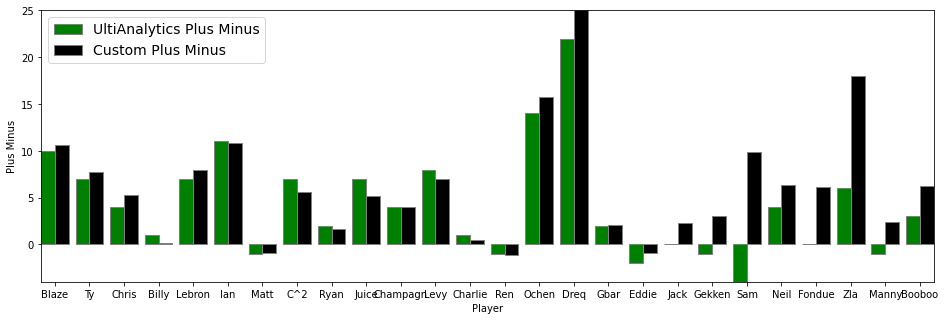

In [75]:
ogPM = playersDF.loc[:,'ogPlusMinus']
plusMinus = playersDF.loc[:,'plusMinus']
width = 0.4
plt.bar(np.arange(len(ogPM)), ogPM, color='g', width=width, edgecolor='grey', label='UltiAnalytics Plus Minus')
plt.bar(np.arange(len(plusMinus)) + width, plusMinus, color='black', width=width, edgecolor='grey', label='Custom Plus Minus')
plt.xlabel('Player')
plt.ylabel('Plus Minus')
plt.legend(loc=2, prop={'size': 14})
plt.xticks(np.arange(len(ogPM)) + width/2, ogPM.index)
fig = plt.gcf()
fig.set_size_inches(figW, figH)
plt.margins(0)
plt.show()

#### Assists v. Hockey Assists

The graph below compares assists to assists (or better known as hockey assists). Hockey assists is not something *UltiAnalytics* explicity tracks which made me curious to see which players were underated in their performace. Compareably to their assists, there is a significant amount of hockey assists in players like Zla, Sam, Jack, and Gbar. This info highlights a players ability to a set up the play to score. 

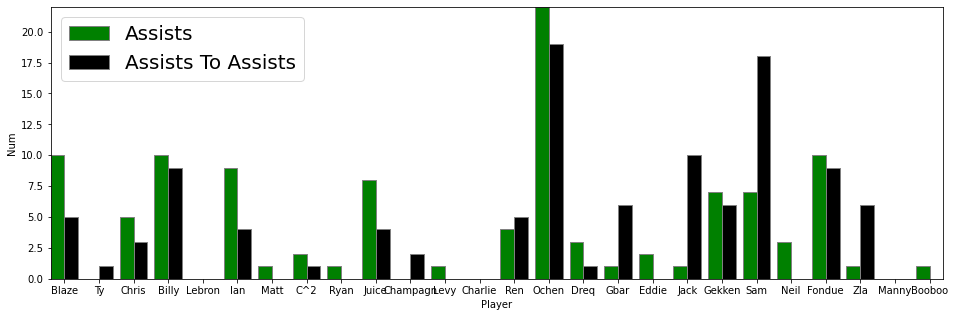

In [74]:

a = playersDF.loc[:,'assists']
aToA = playersDF.loc[:,'assistsToAssists']
width = 0.4
plt.bar(np.arange(len(a)), a, color='green', width=width, edgecolor='grey', label='Assists')
plt.bar(np.arange(len(aToA)) + width, aToA, color='black', width=width, edgecolor='grey', label='Assists To Assists')
plt.xlabel('Player')
plt.ylabel('Num')
plt.legend(loc=2, prop={'size': 20})
plt.xticks(np.arange(len(a)) + width/2, a.index)
fig = plt.gcf()
fig.set_size_inches(figW, figH)
plt.margins(0)
plt.show()

### Chance Of Being Broken

A big part of a good ultimate team is being able to score when you get the disc. Mainly, this means that when you start on offense, you end up scoring that point. Not being able to, and allowing the other team to score even though you started the point on offense is called being broken. A graph below shows an analysis of player's chance of being broken while starting on offense. 

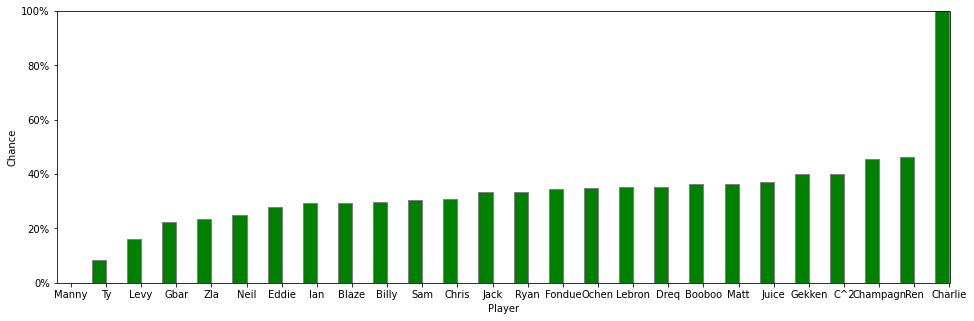

In [16]:

import matplotlib.ticker as mtick

brokenChance = playersDF['brokenChance'].sort_values()
width = 0.4
plt.bar(np.arange(len(brokenChance)), brokenChance, color='green', width=width, edgecolor='grey', label='BrokenChance')
plt.xlabel('Player')
plt.ylabel('Chance')
plt.xticks(np.arange(len(a)) + width/2, brokenChance.index)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
fig = plt.gcf()
fig.set_size_inches(figW, figH)
plt.margins(0)
plt.show()

### Chance Of Breaking

Conversely, an important part about playing defense is about being able to get a break. Meaning, scoring the point even though you started on defense. An analysis of every player's likelyhood of getting a break is shown below

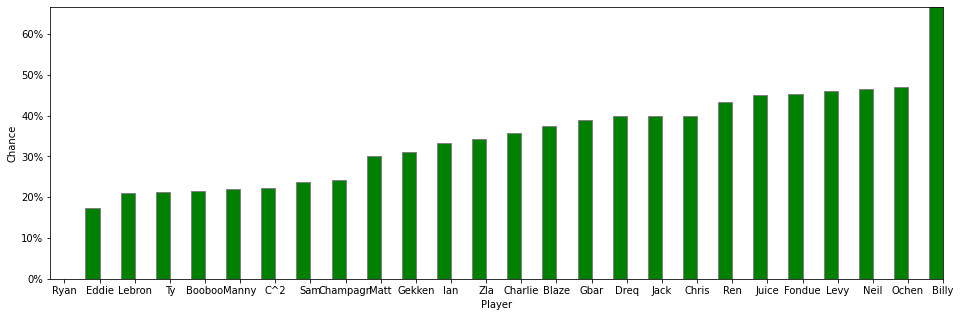

In [17]:

breakChance = playersDF['breakChance'].sort_values()
width = 0.4
plt.bar(np.arange(len(breakChance)), breakChance, color='green', width=width, edgecolor='grey', label='Break Chance')
plt.xlabel('Player')
plt.ylabel('Chance')
plt.xticks(np.arange(len(a)) + width/2, breakChance.index)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
fig = plt.gcf()
fig.set_size_inches(figW, figH)
plt.margins(0)
plt.show()


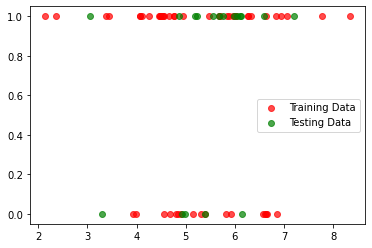

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
pulls = pd.DataFrame(pullsHangTime.keys())
pulls['GeneratedD'] = pd.DataFrame(pullsHangTime.values())
pulls.rename(columns={0: 'Time'})
X_train, X_test, y_train, y_test = train_test_split(list(pullsHangTime.keys()), list(pullsHangTime.values()))
plt.scatter(X_train, y_train, label='Training Data', color='r', alpha=0.7)
plt.scatter(X_test, y_test, label='Testing Data', color='g', alpha=0.7)
plt.legend()
plt.show()

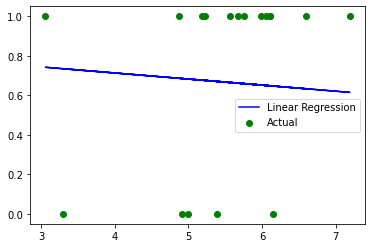

In [19]:
LR = LinearRegression()
LR.fit(np.asarray(X_train).reshape(-1, 1), np.asarray(y_train))
prediction = LR.predict(np.asarray(X_test).reshape(-1, 1))
plt.plot(X_test,prediction, label='Linear Regression', color='b')
plt.scatter(X_test, y_test, label='Actual', color='g')
plt.legend()
plt.show()

In [47]:
from sklearn import model_selection, linear_model, metrics

X_train, X_test, y_train, y_test = model_selection.train_test_split(list(pullsHangTime.keys()), list(pullsHangTime.values()))
model = linear_model.LogisticRegression()
model.fit(np.asarray(X_train).reshape(-1, 1), np.asarray(y_train).reshape(-1, 1))
mat = metrics.confusion_matrix(y_test, model.predict(np.asarray(X_test).reshape(-1, 1)))
mat
y_predict = model.predict(np.asarray(X_test).reshape(-1, 1))
y_predict

/Users/adamcohen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 0,  6],
       [ 0, 12]])

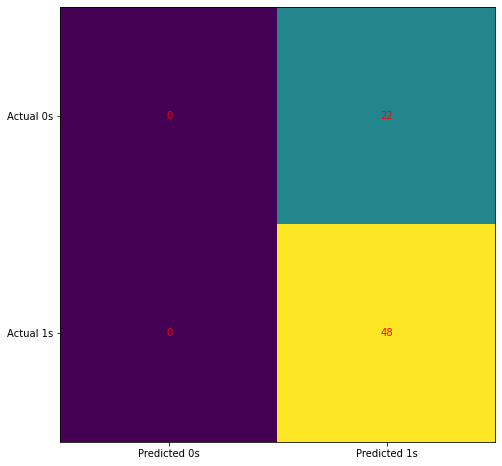

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
model = LogisticRegression(solver='liblinear', random_state=0)
x = list(pullsHangTime.keys())
y = list(pullsHangTime.values())
y = [int(item) for item in y]
x = np.asarray(x).reshape(-1, 1)
y = np.asarray(y)

model.fit(x, y)

cm = confusion_matrix(y, model.predict(x))
cm

## Sourced from: https://realpython.com/logistic-regression-python/
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()


#### Bibliography

* [Analyzing Ultimate](http://karinehsu.github.io/cs109-final-project/website)
* [UltiAnalytics](https://www.ultianalytics.com/app/index.html#/5781282907750400/players?game-0cc51f7d-2792-4fee-b4f8-24fe529675af)
* [AUDL](https://theaudl.com/)